In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from sklearn.preprocessing import minmax_scale
from statsmodels.tsa.stattools import coint
today = datetime.today().strftime("%Y%m%d") 
# start = (datetime.today() - timedelta()).strftime("%Y%m%d") 
# print(start, today)
pd.options.display.float_format = '{:.6f}'.format

Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
cd drive/My Drive/algorithmtrading/pair_trading

/content/drive/My Drive/algorithmtrading/pair_trading


In [ ]:
def one_day(temp,test_day):
    
    begin = np.where( np.array(temp.index) > str(test_day))[0][0]
    end = np.where( str(test_day+1) > np.array(temp.index) )[0][-1]
    
    if len(temp.iloc[begin:end])==0:
        print(test_day,'는 공휴일 입니다.')
    else:
        return temp.iloc[begin-1:end]

# 1. 과거 1분단위 데이터 받아오기

In [ ]:
now = '20210120'

samsung_group = pd.read_pickle('KODEX 200(m)_'+now)
kodex200 = pd.read_pickle('TIGER 200(m)_'+now)

temp =  pd.merge(left = samsung_group , right = kodex200, how = "inner", on = "체결시간")
temp = temp.set_index('체결시간')
temp.columns = ['samsung_group','volume','kodex200','volume']
temp = temp[['samsung_group','kodex200']]

temp['samsung_group']=pd.to_numeric(temp['samsung_group'])
temp['kodex200']=pd.to_numeric(temp['kodex200'])

for i in range(len(temp)):
    if temp['samsung_group'].iloc[i] < 0:
        temp['samsung_group'].iloc[i] = -temp['samsung_group'].iloc[i]
    if temp['kodex200'].iloc[i] < 0:
        temp['kodex200'].iloc[i] = -temp['kodex200'].iloc[i]


temp['kodex200'] = temp['kodex200']
temp['spread'] = temp['samsung_group'] - temp['kodex200']
temp['samsung_group_cumret'] = np.log(temp['samsung_group']/temp['samsung_group'][0])
temp['kodex200_cumret'] = np.log(temp['kodex200']/temp['kodex200'][0])
temp['ma10_spread'] = temp['spread'].rolling(window=10, center=False).mean()

temp

,kodex200,tiger200,spread,kodex200_cumret,tiger200_cumret,ma10_spread
체결시간,,,,,,
20200102100000,29221,29176,45,0.000000,0.000000,nan
20200102100100,29192,29152,40,-0.000993,-0.000823,nan
20200102100200,29206,29166,40,-0.000513,-0.000343,nan
20200102100300,29192,29152,40,-0.000993,-0.000823,nan
20200102100400,29152,29112,40,-0.002364,-0.002196,nan
...,...,...,...,...,...,...
20210119151600,42700,42660,40,0.379311,0.379915,25.000000
20210119151700,42700,42675,25,0.379311,0.380267,25.000000
20210119151800,42720,42690,30,0.379780,0.380618,27.000000


# 2. 일 단위로 데이터 저장하기 + 당일 수익률 계산

In [ ]:
df = {}
calender = []
for date in range(20201021,20210120):
    if 20201231 < date < 20210100:
        continue
    temps = pd.DataFrame()
    temps = one_day(temp,date)
    try:      
        temps['samsung_group_dayret'] = np.log(temps['samsung_group']/temps['samsung_group'][0])
        temps['kodex200_dayret'] = np.log(temps['kodex200']/temps['kodex200'][0])
        temps['spread_cumret'] = temps['samsung_group_cumret'] -temps['kodex200_cumret']
        temps['spread_dayret']= temps['samsung_group_dayret'] - temps['kodex200_dayret'] 
        df[str(date)] = temps
        if len(temps) != 0:
            calender.append(str(date))
    except:
        pass
calender

# 3. 그래프 그리기

In [ ]:
for date in calender[-10:]:
    plt.rcParams["figure.figsize"] = (20, 10)
    df[date]['spread'].plot()
    # df[date]['ma10_spread'].plot()
    # temp_high = df[date]['ma10_spread'] +20
    # temp_low = df[date]['ma10_spread']-20
    # temp_high.plot(linestyle='--')
    # temp_low.plot(linestyle='--')
    # df[date]['samsung_group'].plot()
    # df[date]['kodex200'].plot()
    # plt.axhline((0.0003), color='red', linestyle='--')
    # plt.axhline((-0.0003), color='red', linestyle='--')
    plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (30, 10)
# temp['samsung_group_cumret'].plot()
# temp['samsung_group_cumret'].plot()
# temp['kodex200_cumret'].plot()
temp['samsung_group'].plot()
temp['kodex200'].plot()
# temp['ma30'].plot()

# 4. 스프레드 확인

In [3]:
cd bidask

/content/drive/My Drive/algorithmtrading/pair_trading/bidask


In [9]:
now = '20210122'

samsung_group_bidask = pd.read_pickle('KODEX 삼성그룹_'+now)
kodex200_bidask = pd.read_pickle('KODEX 200_'+now)

bidask =  pd.merge(left = samsung_group_bidask , right = kodex200_bidask, how = "inner", on = "time")
bidask.columns = ['samsung_group_bid','samsung_group_ask','kodex200_bid','kodex200_ask']
bidask['samsung_group_ask'] = bidask['samsung_group_ask']*4
bidask['samsung_group_bid'] = bidask['samsung_group_bid']*4
samsung_group_ask = bidask['samsung_group_ask']
samsung_group_bid = bidask['samsung_group_bid']
kodex200_ask = bidask['kodex200_ask']
kodex200_bid = bidask['kodex200_bid']
bidask

,samsung_group_bid,samsung_group_ask,kodex200_bid,kodex200_ask
time,,,,
095244,43200,43160,43525,43515
095249,43160,43140,43515,43510
095252,43180,43140,43515,43505
095259,43180,43140,43500,43495
095304,43180,43140,43495,43490
...,...,...,...,...
151929,43400,43360,43240,43235
151934,43400,43360,43250,43240
151947,43400,43360,43245,43235


## - bidask 스프레드

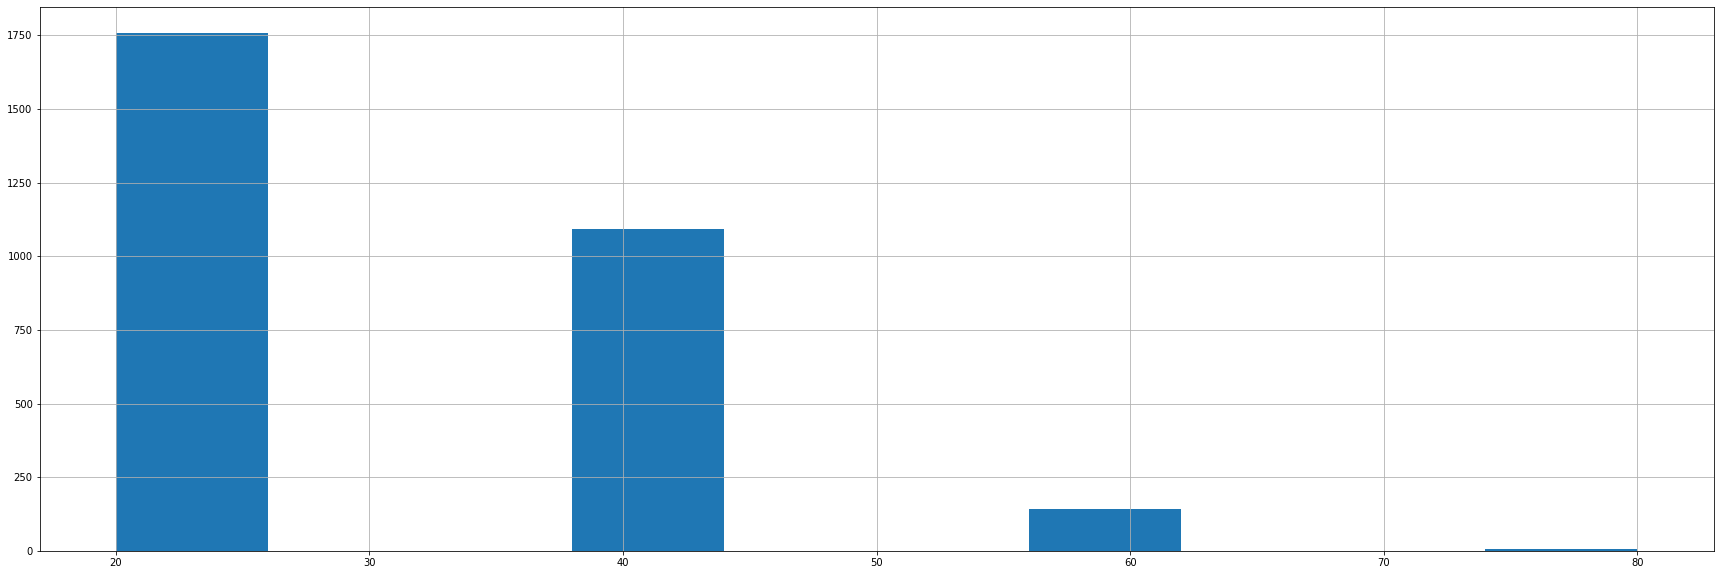

In [10]:
plt.rcParams["figure.figsize"] = (30, 10)
bidask_spread = samsung_group_bid-samsung_group_ask
bidask_spread.hist()

# kodex200_ask_samsung_group_bid spread freaquency    (청산포지션)

-370    59
-365    54
 150    51
-360    48
-375    48
 175    47
-380    45
 15     44
 10     43
-355    42
-115    42
-425    42
-385    41
 155    40
-410    39
-40     39
 160    39
 145    39
-420    36
-430    36
 0      35
 170    35
 20     34
-90     34
-435    34
-120    33
-110    33
-350    33
 5      32
 25     32
dtype: int64


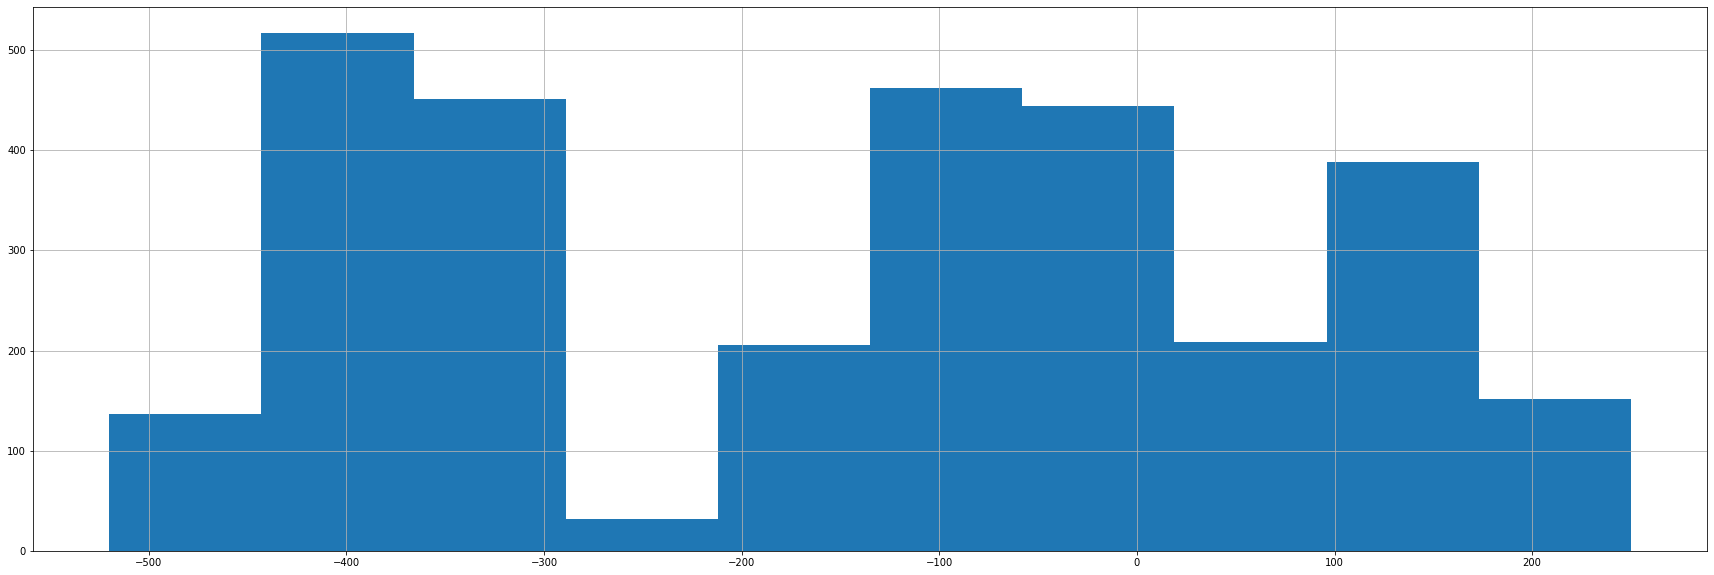

In [11]:
finish = samsung_group_ask - kodex200_bid
finish.hist()
finish = finish.value_counts() 
print(finish[:30])

# samsung_group_ask_kodex200_bid spread freaquency (포지션시작)

 330    64
-200    52
 340    52
 335    47
-175    45
-50     42
-185    42
 315    41
 40     41
 395    41
-205    40
 385    40
 70     40
-180    39
 380    39
 75     38
 345    38
 325    38
 320    38
-25     37
-40     37
 90     37
-195    37
 10     37
 0      37
 15     36
 275    36
-190    35
 65     35
 305    34
dtype: int64


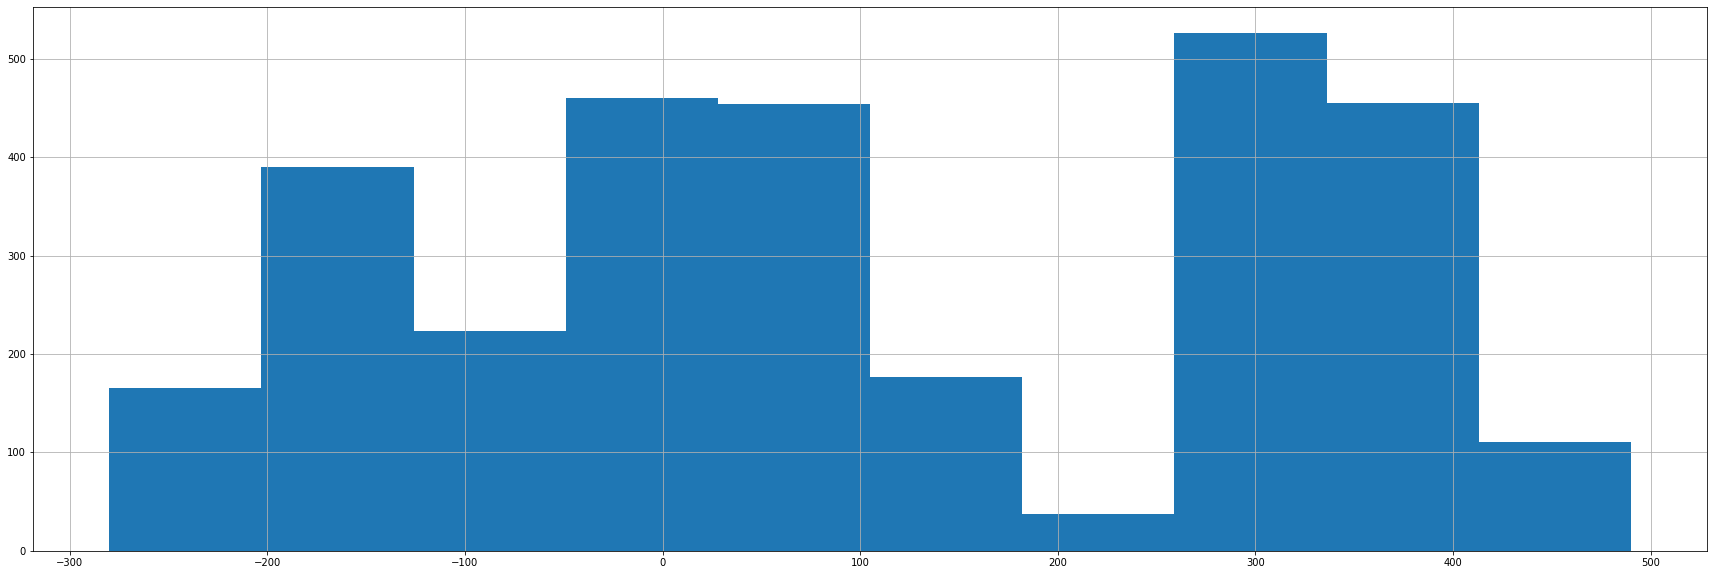

In [12]:
start = kodex200_ask - samsung_group_bid
start.hist()
start = start.value_counts() 
print(start[:30])
# start.mode()[0]

In [ ]:
samsung_group_bidask.mode()

,bid,ask
0,10905,10900


# 시뮬레이션

In [16]:
profit = 0
profits = {}

kodex = 25
samsung_group = 25

init = 25

lev = 1

spread_start = list(map(int,start.index))
spread_finish = list(map(int,finish.index))


for j in spread_start[:30]:
    for k in spread_finish[:30]:
        if j + k <= 3*4:
            continue
        profit = 0
        t = 0
        check = None
        kodex = 25
        samsung_group = 25
        for i in range(len(bidask)):
            if bidask['kodex200_ask'].iloc[i] - bidask['samsung_group_bid'].iloc[i] >= j and init <=samsung_group<= init*2-lev:
                kodex -= lev
                samsung_group += lev
                profit += bidask['kodex200_ask'].iloc[i]*lev - bidask['samsung_group_bid'].iloc[i]*lev
                print('shortstart',i,'번째거래 / ','  ask:',bidask['kodex200_ask'].iloc[i],'  bid:', bidask['samsung_group_bid'].iloc[i],'  profit:',profit)
                t += 5
                check = 'short'
            if bidask['samsung_group_ask'].iloc[i] - bidask['kodex200_bid'].iloc[i] >= k and samsung_group > init and check == 'short':
                profit += bidask['samsung_group_ask'].iloc[i]*(samsung_group - init) - bidask['kodex200_bid'].iloc[i]*(samsung_group-init)
                samsung_group = init
                kodex = init
                print('shortfinish',i,'번째거래 / ','  ask:',bidask['samsung_group_ask'].iloc[i],'  bid:', bidask['kodex200_bid'].iloc[i],'  profit:',profit)       
                t += 5


            if bidask['samsung_group_ask'].iloc[i] - bidask['kodex200_bid'].iloc[i] >= k and init<= kodex<=init*2-lev:
                kodex += lev
                samsung_group -= lev
                profit += bidask['samsung_group_ask'].iloc[i]*lev - bidask['kodex200_bid'].iloc[i]*lev
                print('longstart',i,'번째거래 / ','  ask:',bidask['samsung_group_ask'].iloc[i],'  bid:', bidask['kodex200_bid'].iloc[i],'  profit:',profit)
                t += 5
                check = 'long'
            if bidask['kodex200_ask'].iloc[i] - bidask['samsung_group_bid'].iloc[i] >= j and kodex > init and check == 'long':
                profit += bidask['kodex200_ask'].iloc[i]*(kodex - init) - bidask['samsung_group_bid'].iloc[i]*(kodex-init)
                samsung_group = init
                kodex = init
                print('longfinish',i,'번째거래 / ','  ask:',bidask['kodex200_ask'].iloc[i],'  bid:', bidask['samsung_group_bid'].iloc[i],'  profit:',profit)       
                t += 5
        
        if check == 'short':
            profit += bidask['samsung_group_ask'].iloc[-1]*(samsung_group - init) - bidask['kodex200_bid'].iloc[-1]*(samsung_group-init)
            print('shortfinish',i,'번째거래 / ','  ask:',bidask['samsung_group_ask'].iloc[i],'  bid:', bidask['kodex200_bid'].iloc[i],'  profit:',profit) 
        if check == 'long':
            profit += bidask['kodex200_ask'].iloc[i]*(kodex - init) - bidask['samsung_group_bid'].iloc[i]*(kodex-init)
            print('longfinish',i,'번째거래 / ','  ask:',bidask['kodex200_ask'].iloc[i],'  bid:', bidask['samsung_group_bid'].iloc[i],'  profit:',profit)     

        profits[(j,k,t)] = profit -t*12
        print('-------------------------------------------------------------------------------------------------------------------')

profits = sorted(profits.items(), key=lambda x: x[1], reverse=True)
profits[:20]

Streaming output truncated to the last 5000 lines.
shortstart 12 번째거래 /    ask: 43470   bid: 43160   profit: 4130
shortstart 13 번째거래 /    ask: 43465   bid: 43160   profit: 4435
shortstart 14 번째거래 /    ask: 43465   bid: 43160   profit: 4740
shortstart 15 번째거래 /    ask: 43460   bid: 43160   profit: 5040
shortstart 16 번째거래 /    ask: 43475   bid: 43180   profit: 5335
shortstart 17 번째거래 /    ask: 43470   bid: 43180   profit: 5625
shortstart 18 번째거래 /    ask: 43465   bid: 43180   profit: 5910
shortstart 19 번째거래 /    ask: 43465   bid: 43180   profit: 6195
shortstart 20 번째거래 /    ask: 43460   bid: 43180   profit: 6475
shortstart 21 번째거래 /    ask: 43460   bid: 43180   profit: 6755
shortstart 22 번째거래 /    ask: 43460   bid: 43180   profit: 7035
shortstart 23 번째거래 /    ask: 43450   bid: 43180   profit: 7305
shortstart 24 번째거래 /    ask: 43450   bid: 43180   profit: 7575
shortfinish 1967 번째거래 /    ask: 43560   bid: 43555   profit: 7700
longstart 1967 번째거래 /    ask: 43560   bid: 43555   profit: 7705


[((395, 175, 255), 12490),
 ((385, 175, 255), 12305),
 ((380, 175, 255), 12190),
 ((395, 170, 255), 12160),
 ((385, 170, 255), 11975),
 ((380, 170, 255), 11860),
 ((395, 160, 255), 11705),
 ((395, 155, 255), 11585),
 ((395, 150, 255), 11565),
 ((385, 160, 255), 11520),
 ((395, 145, 255), 11485),
 ((380, 160, 255), 11405),
 ((385, 155, 255), 11400),
 ((385, 150, 255), 11380),
 ((385, 145, 255), 11300),
 ((380, 155, 255), 11285),
 ((380, 150, 255), 11265),
 ((345, 175, 255), 11245),
 ((380, 145, 255), 11185),
 ((340, 175, 255), 11110)]

In [ ]:
profit = 0
t = 0 ; j = 32980 ; k = -32510

kodex = 40
samsung_group = 40

for i in range(len(bidask)):
    if bidask['kodex200_ask'].iloc[i] - bidask['samsung_group_bid'].iloc[i] >= j and init <=samsung_group<= init*2-lev:
        kodex -= lev
        samsung_group += lev
        profit += bidask['kodex200_ask'].iloc[i]*lev - bidask['samsung_group_bid'].iloc[i]*lev
        print('shortstart',i,'번째거래 / ','  ask:',bidask['kodex200_ask'].iloc[i],'  bid:', bidask['samsung_group_bid'].iloc[i],'  profit:',profit)
        t += 2
        check = 'short'
    if bidask['samsung_group_ask'].iloc[i] - bidask['kodex200_bid'].iloc[i] >= k and samsung_group > init and check == 'short':
        profit += bidask['samsung_group_ask'].iloc[i]*(samsung_group - init) - bidask['kodex200_bid'].iloc[i]*(samsung_group-init)
        samsung_group = init
        kodex = init
        print('shortfinish',i,'번째거래 / ','  ask:',bidask['samsung_group_ask'].iloc[i],'  bid:', bidask['kodex200_bid'].iloc[i],'  profit:',profit)       
        t += 2


    if bidask['samsung_group_ask'].iloc[i] - bidask['kodex200_bid'].iloc[i] >= k and init<= kodex<=init*2-lev:
        kodex += lev
        samsung_group -= lev
        profit += bidask['samsung_group_ask'].iloc[i]*lev - bidask['kodex200_bid'].iloc[i]*lev
        print('longstart',i,'번째거래 / ','  ask:',bidask['samsung_group_ask'].iloc[i],'  bid:', bidask['kodex200_bid'].iloc[i],'  profit:',profit)
        t += 2
        check = 'long'
    if bidask['kodex200_ask'].iloc[i] - bidask['samsung_group_bid'].iloc[i] >= j and kodex > init and check == 'long':
        profit += bidask['kodex200_ask'].iloc[i]*(kodex - init) - bidask['samsung_group_bid'].iloc[i]*(kodex-init)
        samsung_group = init
        kodex = init
        print('longfinish',i,'번째거래 / ','  ask:',bidask['kodex200_ask'].iloc[i],'  bid:', bidask['samsung_group_bid'].iloc[i],'  profit:',profit)       
        t += 2

if check == 'short':
    profit += bidask['samsung_group_ask'].iloc[-1]*(samsung_group - init) - bidask['kodex200_bid'].iloc[-1]*(samsung_group-init)
    print('shortfinish',i,'번째거래 / ','  ask:',bidask['samsung_group_ask'].iloc[i],'  bid:', bidask['kodex200_bid'].iloc[i],'  profit:',profit) 
if check == 'long':
    profit += bidask['kodex200_ask'].iloc[i]*(kodex - init) - bidask['samsung_group_bid'].iloc[i]*(kodex-init)
    print('longfinish',i,'번째거래 / ','  ask:',bidask['kodex200_ask'].iloc[i],'  bid:', bidask['samsung_group_bid'].iloc[i],'  profit:',profit)     

print(profit -t*9)
print('-------------------------------------------------------------------------------------------------------------------')

shortstart 418 번째거래 /    ask: 43830   bid: 10850   profit: 32980
shortstart 419 번째거래 /    ask: 43840   bid: 10855   profit: 65965
shortstart 420 번째거래 /    ask: 43840   bid: 10855   profit: 98950
shortstart 421 번째거래 /    ask: 43870   bid: 10855   profit: 131965
shortstart 422 번째거래 /    ask: 43865   bid: 10860   profit: 164970
shortstart 423 번째거래 /    ask: 43855   bid: 10860   profit: 197965
shortstart 424 번째거래 /    ask: 43860   bid: 10865   profit: 230960
shortstart 425 번째거래 /    ask: 43865   bid: 10865   profit: 263960
shortstart 426 번째거래 /    ask: 43855   bid: 10865   profit: 296950
shortstart 427 번째거래 /    ask: 43870   bid: 10865   profit: 329955
shortstart 428 번째거래 /    ask: 43885   bid: 10865   profit: 362975
shortstart 429 번째거래 /    ask: 43875   bid: 10865   profit: 395985
shortstart 430 번째거래 /    ask: 43870   bid: 10865   profit: 428990
shortstart 431 번째거래 /    ask: 43865   bid: 10865   profit: 461990
shortstart 433 번째거래 /    ask: 43845   bid: 10865   profit: 494970
shortstart 57